In [8]:
# show log-max assumption
# show reconstruction using FHMM to de-noise
# show how correct state is found when there is a lot of noise
import numpy as np

# view data
import sys
sys.path.append("/Users/david/Documents/mastersCode/ubm")
print(sys.path)

['/Applications/PyCharm.app/Contents/plugins/python/helpers-pro/jupyter_debug', '/Applications/PyCharm.app/Contents/plugins/python/helpers/pydev', '/Users/david/Documents/mastersCode/ubm/final/fhmm', '/Users/david/.conda/envs/ubm/lib/python310.zip', '/Users/david/.conda/envs/ubm/lib/python3.10', '/Users/david/.conda/envs/ubm/lib/python3.10/lib-dynload', '', '/Users/david/.conda/envs/ubm/lib/python3.10/site-packages', '/Users/david/Documents/mastersCode/ubm', '/Users/david/Documents/mastersCode/ubm']


In [9]:
import pandas as pd
import importlib
from whale.setup import get_data, constants, annotations
importlib.reload(get_data)
importlib.reload(annotations)
importlib.reload(constants)
from python_speech_features import mfcc, delta
import numpy as np
from spafe.utils import vis
import matplotlib.pyplot as plt
import IPython
from scipy.io import wavfile
from final.useful import *

In [10]:
get_data_whale = get_data.GetDataBase(
    location_of_wav_file=constants.HUMPBACK_WAV_A,
    location_of_annotations=constants.SWOOPS_LABELS_A,
    annotations=annotations.AnnotationsAudacity(),
    window_length=0.025, frame_step=0.01, samples=False, sr=None)

get_data_noise = get_data.GetDataBase(
    location_of_wav_file=constants.HUMPBACK_WAV_A,
    location_of_annotations=constants.HUMPBACK_LABEL_A_NOISE,
    annotations=annotations.AnnotationsAudacity(),
    window_length=0.025, frame_step=0.01, samples=False, sr=None)


In [14]:
# define constants

import librosa
_, audio_fs = librosa.load(constants.HUMPBACK_WAV_A, sr=None)

nfilts = 200
nfft = 256

def get_feature(sample, nfft):
    return np.log(np.abs(librosa.stft(sample, n_fft=nfft)).T)

In [15]:
from spafe.features import mfcc

# normalisation / feature extraction
import librosa.util as util
audio_normalised = util.normalize(get_data_whale.audio)

# create labels and data
whale_samples = []
whale_features = []
noise_features = []
noise_samples = []

for i in range(len(get_data_whale.annotations.annotations)):
    annot = get_data_whale.annotations.annotations[i]
    sample = audio_normalised[annot.start:annot.end]
    whale_samples.append(sample)
    whale_features.append(get_feature(sample, nfft))

for i in range(len(get_data_noise.annotations.annotations)):
    annot = get_data_noise.annotations.annotations[i]
    sample = audio_normalised[annot.start:annot.end]
    noise_samples.append(sample)
    noise_features.append(get_feature(sample, nfft))

# hmm_noise.fit()

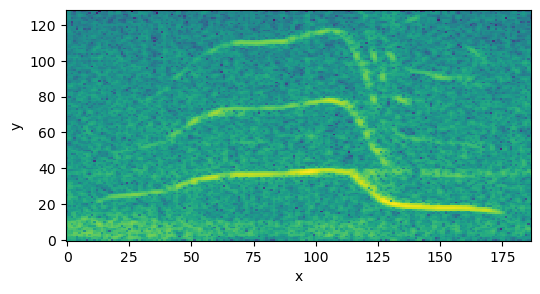

In [16]:
vis_helper(whale_features[0])

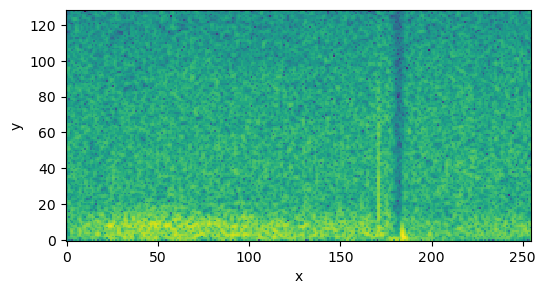

In [17]:
vis_helper(noise_features[20])

In [56]:
# not completely sure about how to accommodate for power between signals
from hmmlearn.hmm import GaussianHMM
hmm_whale = GaussianHMM(15)
[len(feat) for feat in whale_features]
hmm_whale.fit(np.concatenate(whale_features))

GaussianHMM(n_components=15)

In [30]:
def generate_gaussian_noise(num_samples, power_a, power_b, power_c):
    # Define the parameters of the HMM
    startprob = np.array([0.3, 0.3, 0.4])
    transmat = np.array([[0.999, 0.0005, 0.0005], [0.0005, 0.999, 0.0005], [0.0005,0.0005, 0.999]])  # Transition matrix
    means = np.array([[0.0], [0.0], [0.0]])  # Mean values for each state
    covars = np.array([[[power_a]],[[power_b]],[[power_c]]])  # Covariance matrices for each state

    # Create a two-state HMM
    model = GaussianHMM(n_components=len(startprob), covariance_type="full", n_iter=100)
    model.n_features = 1
    model.startprob_ = startprob
    model.transmat_ = transmat
    model.means_ = means
    model.covars_ = covars

    # Generate samples from the HMM
    noise, states = model.sample(num_samples)

    return noise.flatten(), states

In [175]:
import noisey
importlib.reload(noisey)
snr_1 = noisey.get_noise_avg_watts(whale_samples[2], 15)
snr_2 = noisey.get_noise_avg_watts(whale_samples[2], 3)
snr_3 = noisey.get_noise_avg_watts(whale_samples[2], 3)
gauss_noise, ss = generate_gaussian_noise(len(whale_samples[2]),snr_1 , snr_2, snr_3)

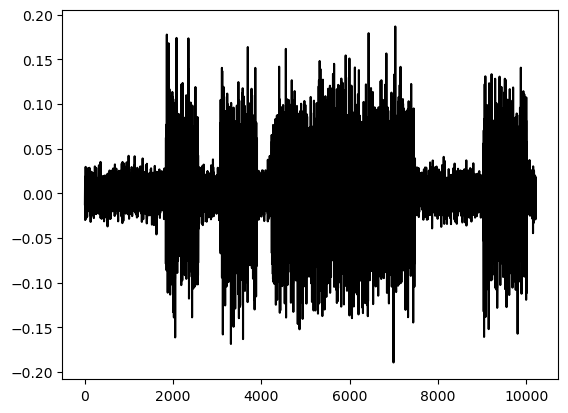

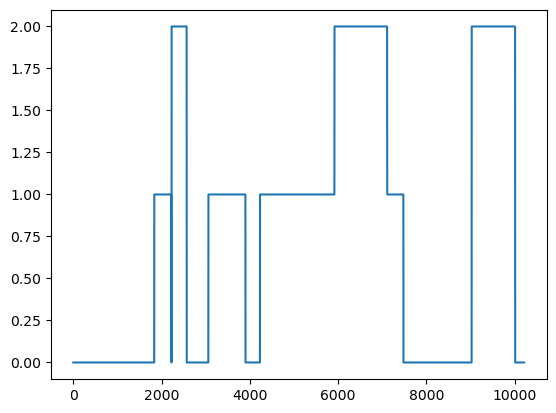

In [176]:
plt.plot(gauss_noise, c='black')
plt.show()
plt.plot(ss)

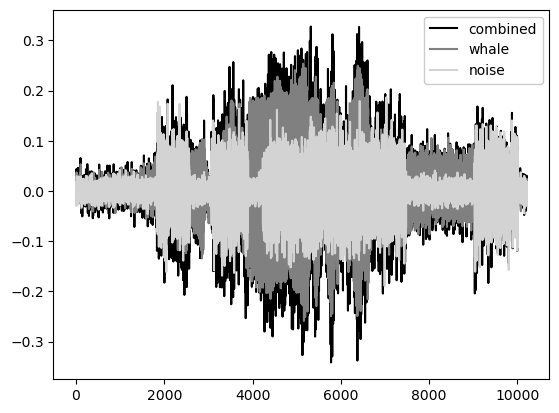

In [195]:
combined_time_domain = whale_samples[2] + gauss_noise.flatten()

plt.plot(combined_time_domain, c='black', label='combined')
plt.plot(whale_samples[2], c='grey', label='whale')
plt.plot(gauss_noise, c='lightgrey', label='noise')
plt.legend(loc='upper right', facecolor='white',framealpha=1)
plt.savefig('time-domain-combined')

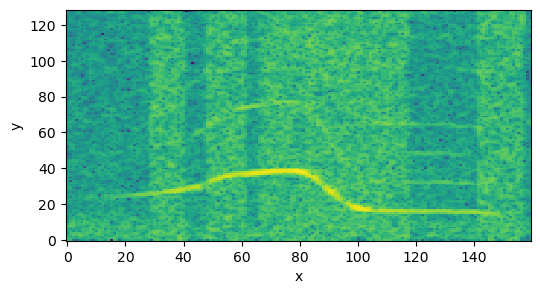

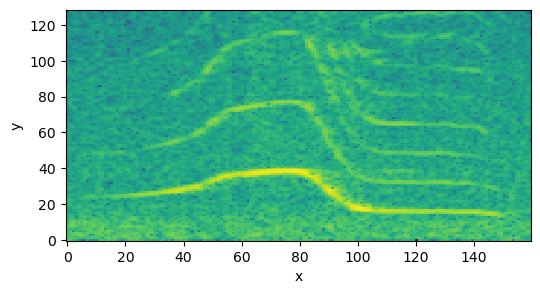

<Figure size 640x480 with 0 Axes>

In [191]:
combined_features = get_feature(combined_time_domain, nfft=nfft)
vis_helper(combined_features)
vis_helper(whale_features[2])


In [183]:
hmm_noise = GaussianHMM(2)
hmm_noise_feat = get_feature(gauss_noise, nfft=nfft)

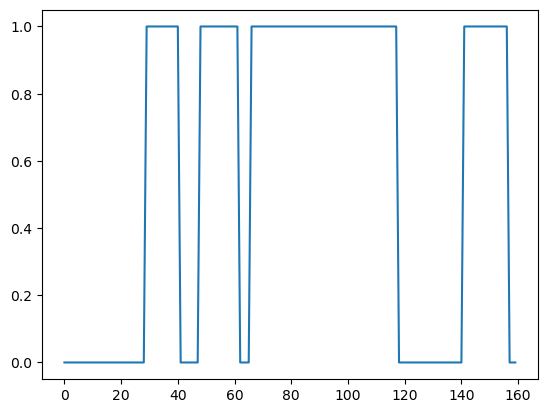

In [184]:
hmm_noise.fit(hmm_noise_feat)
_, ss = hmm_noise.decode(hmm_noise_feat)
plt.plot(ss)

In [185]:
import hmmUtils
importlib.reload(hmmUtils)

<module 'hmmUtils' from '/Users/david/Documents/mastersCode/ubm/hmmUtils.py'>

In [186]:
ViterbiAlgorithmParallel = hmmUtils.doViterbiAlgorithmParallel(combined_features, hmm_whale, hmm_noise)
ViterbiAlgorithmHmmLearn = hmm_whale.decode(whale_features[2])

In [187]:
ViterbiAlgorithmHmmLearnOnCombined = hmm_whale.decode(combined_features)
ViterbiAlgorithmHmmLearnOnCombinedNoise = hmm_noise.decode(combined_features)

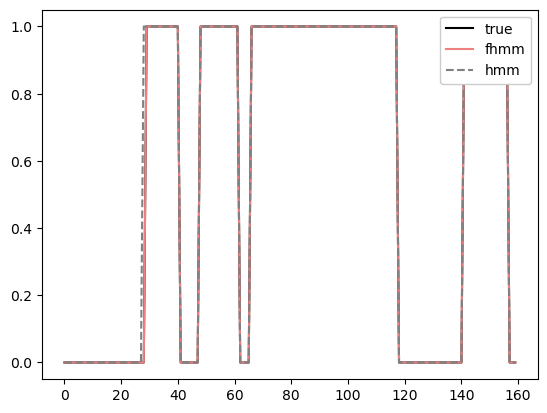

In [194]:

# plt.plot(ViterbiAlgorithmHmmLearn[1], '-', c='black', label='true')
# plt.plot(ViterbiAlgorithmParallel[1][0], '-', c='lightcoral', label='fhmm')
# plt.plot(ViterbiAlgorithmHmmLearnOnCombined[1], '--', c='grey', label='hmm')

plt.plot(ss, '-', c='black', label='true')
plt.plot(ViterbiAlgorithmParallel[1][1], '-', c='lightcoral', label='fhmm')
plt.plot(ViterbiAlgorithmHmmLearnOnCombinedNoise[1], '--', c='grey', label='hmm')
plt.legend(loc='upper right', facecolor='white',framealpha=1)
plt.savefig('noise-states-recovered.png')

In [54]:
# weiner filter

p1 = hmmUtils.inputParams(hmm_whale.means_, ViterbiAlgorithmParallel[1][0])
p2 = hmmUtils.inputParams(hmm_noise.means_, ViterbiAlgorithmParallel[1][1])

mask01, mask02 = hmmUtils.weinerFilter.getSoftMask(combined_features, p1, p2)

whale_recovered = ((combined_features) * mask01)
noise_recovered = (combined_features * mask02)

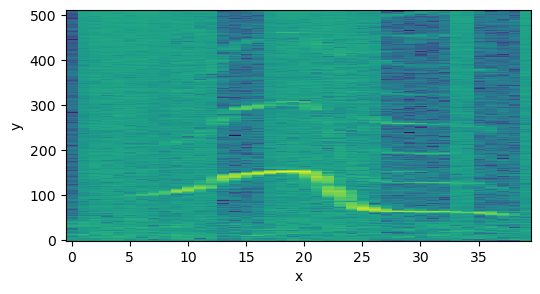

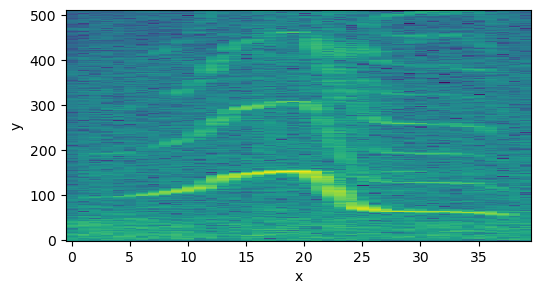

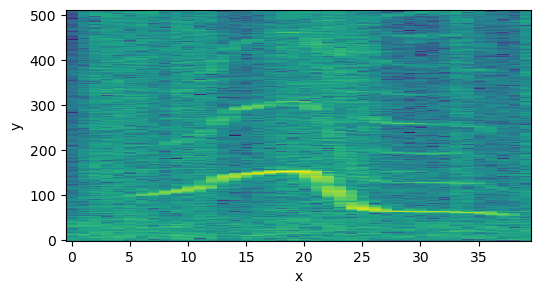

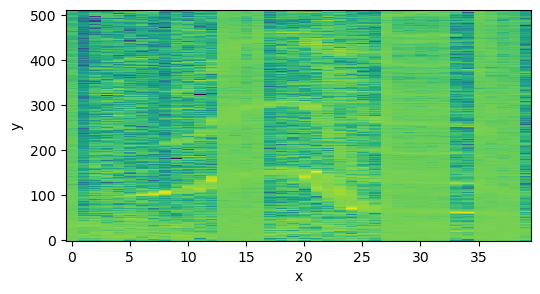

In [55]:
vis_helper(whale_recovered)
vis_helper(whale_features[2])
vis_helper(combined_features)
vis_helper(noise_recovered)

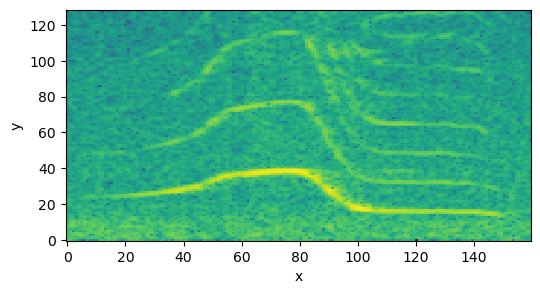

In [132]:
# use only STFT for ease
whale_sample_test = whale_samples[2][np.newaxis, :]
y_test = np.log(np.abs(librosa.stft(whale_sample_test, n_fft=256)[0]))
vis_helper(y_test.T)

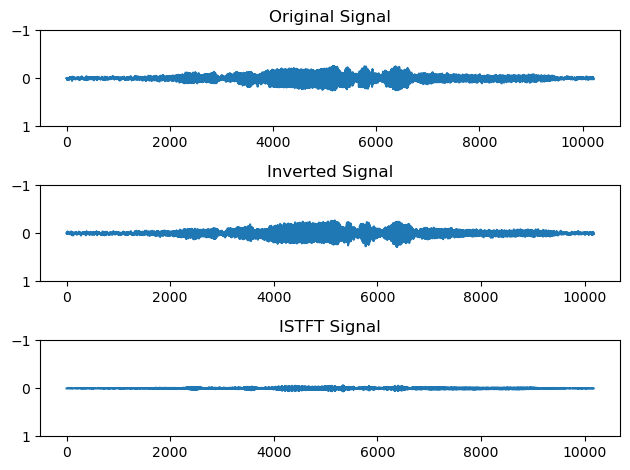

In [134]:
# Invert using Griffin-Lim
y_inv = librosa.griffinlim(np.exp(y_test), n_fft=256)
# Invert without estimating phase
y_istft = librosa.istft(np.exp(y_test), n_fft=256)

plt.subplot(3, 1, 1)
plt.plot(whale_sample_test[0])
plt.title('Original Signal')
plt.ylim([1,-1])  # Set y-axis limits

# Plot inverted signal
plt.subplot(3, 1, 2)
plt.plot(y_inv)
plt.title('Inverted Signal')
plt.ylim([1,-1])  # Set y-axis limits

# Plot ISTFT signal
plt.subplot(3, 1, 3)
plt.plot(y_istft)
plt.title('ISTFT Signal')
plt.ylim([1,-1])  # Set y-axis limits

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()